In [1]:
from scipy import pi
import numpy as np
import pandas as pd

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import cv2
import scipy.misc
import csv

from keras.models import *
from keras.optimizers import *
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, Lambda, Flatten, Dense

Populating the interactive namespace from numpy and matplotlib


/home/hp/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
angle_rad = []

with open("/home/hp/self driving car/driving_dataset/data.txt") as f:
     for line in f:
         image, angle_deg = line.strip().split()
         angle_rad.append(float(angle_deg) * pi / 180)   
        
print("preprocessing complete") 

print(len(angle_rad))
print(angle_rad[136])
#print(angle_deg)

preprocessing complete
45406
0.1706932008450454


In [5]:

split_index = int(len(angle_rad)*.8)
train_angle = angle_rad[:split_index]
test_angle = angle_rad[split_index:]

print(len(train_angle))
print(len(test_angle))

36324
9082


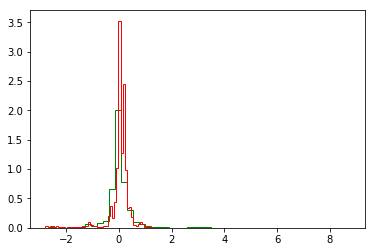

In [7]:
#PDF of train_angle and test_angle


plt.hist(train_angle, bins=50, normed=1, color='green', histtype='step')
plt.hist(test_angle, bins=50, normed=1, color='red', histtype='step')
plt.show()

1. The PDFs of train_angle and test_angle are not exactly the same, because this is temporal data. The distribution of steering angle (train_data) in first 80% of total time is different from that of last 20% of total time (test_angle).

2. In both the distributions, a steering angle of 0 degree is recorded mosrly.

In [8]:
mean_train_angle = np.mean(train_angle)
print(mean_train_angle)

print("test error w.r.t. mean train angle : %f" % np.mean(np.square(test_angle - mean_train_angle)))
print("test error w.r.t zero : %f" % np.mean(np.square(np.array(test_angle) - 0.0)))

0.0345988749016117
test error w.r.t. mean train angle : 0.191127
test error w.r.t zero : 0.190891


A mean squared error (test error) with respect to zero is less than with respect to mean train angle.

In [2]:
#splits the dataset into training set and test set

image = []
angle_rad = []

with open("/home/hp/self driving car/driving_dataset/data.txt") as f:     
    for line in f:
        image_name, angle_deg = line.strip().split()
        
        img = cv2.imread("/home/hp/self driving car/driving_dataset/" + image_name)
        img = cv2.resize(img,(66, 200))
        image.append(img)  
        
        angle_rad.append(float(angle_deg) * pi / 180)

image = image[:30000]        
print('-'*40)
print(len(image))
print('-'*40)      
numpy_image = np.array(image)
print(numpy_image[0].shape)
print('-'*40)
print(type(numpy_image))
print('-'*40)
print(type(numpy_image))
print('-'*40)
print(numpy_image.shape)

angle_rad = angle_rad[:30000]

split_index = int(len(angle_rad)*.8)

numpy_angle = np.array(angle_rad)
train_angle = numpy_angle[:split_index]
test_angle = numpy_angle[split_index:]
print(len(train_angle))
print(len(test_angle))
print('-'*40)

train_image = numpy_image[:split_index]
test_image = numpy_image[split_index:]

print(len(train_image))
print(len(test_image))



----------------------------------------
30000
----------------------------------------
(200, 66, 3)
----------------------------------------
<class 'numpy.ndarray'>
----------------------------------------
<class 'numpy.ndarray'>
----------------------------------------
(30000, 200, 66, 3)
24000
6000
----------------------------------------
24000
6000


1. 30,000 out of 45,000+ data points are used for this project.

2. First 80% of 30k temporal data points is used for training, and the rest is used for testing.

In [3]:
min = np.amin(train_angle)
print(min)
print('-'*40)
max = np.amax(train_angle)
print(max)
print('-'*40)
#print(train_image[0])
print('-'*40)
min = np.amin(train_image)
print(min)
print('-'*40)
max = np.amax(train_image)
print(max)
print('-'*40)
print(split_index)

-2.6680848275237317
----------------------------------------
8.757713120657145
----------------------------------------
----------------------------------------
0
----------------------------------------
255
----------------------------------------
24000


In [4]:
#the CNN model

img_rows = 200
img_cols = 66

#L2NormConst = 0.001

#def mse_reg_loss(smooth, thresh):
    #return tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst

def nvidia_net():

    inputs = Input((img_rows, img_cols, 3))

    #Normalization layers
    #norm = Lambda(lambda x: x/255.0 -0.5)(inputs)

    #Convolution layers
    conv1 = Conv2D(24, 5, strides=(2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    print("conv1 shape:",conv1.shape)
      
    conv2 = Conv2D(36, 5, strides=(2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    print("conv2 shape:",conv2.shape)

    conv3 = Conv2D(48, 5, strides=(2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    print("conv3 shape:",conv3.shape)

    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    print("conv4 shape:",conv4.shape)

    conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    print("conv5 shape:",conv5.shape)

    #Flattening
    flat = Flatten()(conv5)

    #Fully connected layers
    dense1 = Dense(100, activation = 'relu', use_bias=True, kernel_initializer = 'he_normal')(flat)
    drop1 = Dropout(0.5)(dense1)

    dense2 = Dense(50, activation = 'relu', use_bias=True, kernel_initializer = 'he_normal')(drop1)
    drop2 = Dropout(0.5)(dense2)

    dense3 = Dense(10, activation = 'relu', use_bias=True, kernel_initializer = 'he_normal')(drop2)
    print("dense3 shape:",dense3.shape)
    drop3 = Dropout(0.5)(dense3)

    dense4 = Dense(1, activation = 'sigmoid', use_bias=True, kernel_initializer = 'he_normal')(drop3)

    model = Model(input = inputs, output = dense4)

    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
                
    optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=0.00000001, decay=0.0)

    #model.compile(optimizer = optimizer, loss = 'mse', metrics=['binary_accuracy'])
    model.compile(optimizer = optimizer, loss = 'mse')

    return model

******* train_image ********
[[[[-0.20021673 -0.9533888  -0.8435512 ]
   [-0.796478   -0.7023315  -0.90631557]
   [-0.9533888  -0.92200667 -0.7337136 ]
   ...
   [ 0.22344258 -0.10607021  0.05084064]
   [ 0.25482476 -0.16883455  0.05084064]
   [ 0.22344258 -0.02761479  0.17636932]]

  [[-0.4669652  -1.0475353  -0.8278602 ]
   [-0.8435512  -0.796478   -0.984771  ]
   [-0.7807869  -0.9690799  -0.5768028 ]
   ...
   [ 0.19206041 -0.0119237   0.12929606]
   [ 0.27051583 -0.18452564  0.16067824]
   [-0.0119237  -0.05899696  0.11360499]]

  [[-0.7494047  -1.0946087  -0.8592423 ]
   [-0.7337136  -0.8749334  -0.9533888 ]
   [-0.6709493  -0.93769777 -0.5611117 ]
   ...
   [ 0.05084064 -0.02761479  0.03514956]
   [ 0.28620693 -0.15314347  0.22344258]
   [ 0.0979139   0.03514956  0.12929606]]

  ...

  [[-0.8435512  -1.4084303  -1.0946087 ]
   [-1.1259907  -1.2829016  -1.173064  ]
   [-1.0789175  -1.2672106  -1.2829016 ]
   ...
   [-1.5967233  -1.5025768  -1.533959  ]
   [-1.5653412  -1.5496501  

conv1 shape: (?, 100, 33, 24)
conv2 shape: (?, 50, 17, 36)
conv3 shape: (?, 25, 9, 48)
conv4 shape: (?, 25, 9, 64)
conv5 shape: (?, 25, 9, 64)
dense3 shape: (?, 10)


/home/hp/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


got nvidia_net
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 66, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 33, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 17, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 9, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 9, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 9, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)             0     

/home/hp/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:48: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 19200 samples, validate on 4800 samples
Epoch 1/40
 - 420s - loss: 0.4153 - val_loss: 0.0331

Epoch 00001: loss improved from inf to 0.41534, saving model to nvidia_net.hdf5
Epoch 2/40
 - 348s - loss: 0.3926 - val_loss: 0.0504

Epoch 00002: loss improved from 0.41534 to 0.39256, saving model to nvidia_net.hdf5
Epoch 3/40
 - 348s - loss: 0.3653 - val_loss: 0.0416

Epoch 00003: loss improved from 0.39256 to 0.36529, saving model to nvidia_net.hdf5
Epoch 4/40
 - 349s - loss: 0.3430 - val_loss: 0.0470

Epoch 00004: loss improved from 0.36529 to 0.34297, saving model to nvidia_net.hdf5
Epoch 5/40
 - 413s - loss: 0.3268 - val_loss: 0.0513

Epoch 00005: loss improved from 0.34297 to 0.32685, saving model to nvidia_net.hdf5
Epoch 6/40
 - 398s - loss: 0.3107 - val_loss: 0.0599

Epoch 00006: loss improved from 0.32685 to 0.31068, saving model to nvidia_net.hdf5
Epoch 7/40
 - 393s - loss: 0.2996 - val_loss: 0.0920

Epoch 00007: loss improved from 0.31068 to 0.29959, saving model to nvidi

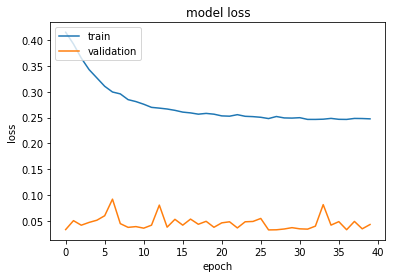

In [5]:
#trains the model

def train(train_image, train_angle):

        #print("loading data")
        #imgs_train, imgs_mask_train, imgs_test = self.load_data()
        #print("loading data done")
        '''Train_data_image2 = resize_arr(Train_data_image)
        Train_data_mask2 = resize_arr(Train_data_mask)'''
        
        train_image = train_image.astype('float32')
        mean = np.mean(train_image)  # mean for data centering
        std = np.std(train_image)  # std for data normalization

        train_image -= mean
        train_image /= std
        print("******* train_image ********")
        print(train_image)
        print(train_image.shape)

        train_angle  = train_angle.astype('float32')
        #train_angle  /= 255. # scale masks to [0, 1]
        print("******* train_angle ********")
        print(train_angle)
        print(train_angle.shape)
        
        #np.reshape(a, (2, 3)) 
        #np.reshape(Train_data_image[0][0], (512, 512, 3)) 
        
        # keras library import  for Saving and loading model and weights
            
        model = nvidia_net()
        print("got nvidia_net")
        model.summary()
        
        # serialize model to JSON
        #  the keras model which is trained is defined as 'model' in this example
        #model_json = model.to_json()
        
        #with open("model_num.json", "w") as json_file:
             #json_file.write(model_json)
                
        # serialize weights to HDF5
        #model.save_weights("model_num.h5")        

        model_checkpoint = ModelCheckpoint('nvidia_net.hdf5', monitor='loss',verbose=1, save_best_only=True)
        print('Fitting model...')
        history = model.fit(train_image, train_angle, batch_size=50, nb_epoch=40, verbose=2, validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
        
        #model.load_weights('unet.hdf5')
        
        '''Test_data_image2 = resize_arr(Test_data_image)
            
        Test_data_image2 =  Test_data_image2.astype('float32')
        Test_data_image2 -= mean
        Test_data_image2 /= std 
        
        #Test_data_mask2 = resize_arr(Test_data_mask)
            
        #Test_data_mask2  = Test_data_mask2.astype('float32')
        #Test_data_mask2  /= 255.
        
        print('predict test data')
        Test_data_mask_predict = model.predict(Test_data_image2, batch_size=1, verbose=1)'''
        
        # list all data in history
        print(history.history.keys())
        '''# summarize history for accuracy
        plt.plot(history.history['train_mse'])
        plt.plot(history.history['val_mse'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()'''
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show() 
        
        return model

model = train(train_image, train_angle)        

In [8]:
#tests the model

#model = load_model('nvidia_net.hdf5')
predicted_angle_rad = model.predict(test_image, batch_size = 1)
print(predicted_angle_rad)
print(len(predicted_angle_rad))
predicted_angle_deg = (predicted_angle_rad*180)/pi
print(predicted_angle_deg)
#print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))

test_angle_deg = (test_angle*180)/pi




[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
6000
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [9]:
#creates a CSV file which stores the original test angles (in degree) and the corresponding predicted angles (in degree)
#by the model
    
df = pd.DataFrame()
df['test_angle_deg']  = test_angle_deg
df['predicted_angle_deg'] = predicted_angle_deg
print(df)
df.to_csv('predicted_angle.csv', encoding='utf-8', index=False)

      test_angle_deg  predicted_angle_deg
0               2.32                  0.0
1               1.92                  0.0
2               1.51                  0.0
3               1.31                  0.0
4               1.31                  0.0
5               0.00                  0.0
6               1.01                  0.0
7               0.91                  0.0
8               0.81                  0.0
9               0.71                  0.0
10              0.61                  0.0
11              0.61                  0.0
12              0.50                  0.0
13              0.50                  0.0
14              0.50                  0.0
15              0.50                  0.0
16              0.40                  0.0
17              0.30                  0.0
18              0.20                  0.0
19              0.20                  0.0
20              0.20                  0.0
21              0.20                  0.0
22              0.20              

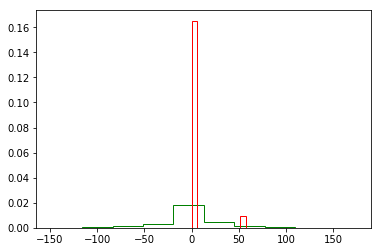

In [13]:
#PDF of original test angles (test_angle_deg) and predicted test angles (predicted_angle_deg)


plt.hist(test_angle_deg, bins=10, normed=1, color='green', histtype='step')
plt.hist(predicted_angle_deg, bins=10, normed=1, color='red', histtype='step')
plt.show()